<a href="https://colab.research.google.com/github/plthiyagu/Personnel/blob/master/Next_Word_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://thecleverprogrammer.com/2020/07/20/next-word-prediction-model/

In [33]:
import regex
import pandas as pd
import numpy as np
from nltk.tokenize import RegexpTokenizer
from keras.models import Sequential, load_model
from keras.layers import Dense,Activation
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import heapq

In [34]:
!wget https://raw.githubusercontent.com/plthiyagu/Personnel/master/Dataset/Next%20Word%20Prediction%20Dataset.txt

--2020-10-24 04:02:22--  https://raw.githubusercontent.com/plthiyagu/Personnel/master/Dataset/Next%20Word%20Prediction%20Dataset.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 595481 (582K) [text/plain]
Saving to: ‘Next Word Prediction Dataset.txt.1’

Next Word Predictio 100%[===================>] 581.52K  3.05MB/s    in 0.2s    

2020-10-24 04:02:23 (3.05 MB/s) - ‘Next Word Prediction Dataset.txt.1’ saved [595481/595481]



In [35]:
path = '/content/Next Word Prediction Dataset.txt'
text = open(path).read().lower()
print('corpus length:', len(text))

corpus length: 581888


In [36]:
text

'\nproject gutenberg\'s the adventures of sherlock holmes, by arthur conan doyle\n\nthis ebook is for the use of anyone anywhere at no cost and with\nalmost no restrictions whatsoever.  you may copy it, give it away or\nre-use it under the terms of the project gutenberg license included\nwith this ebook or online at www.gutenberg.net\n\n\ntitle: the adventures of sherlock holmes\n\nauthor: arthur conan doyle\n\nrelease date: november 29, 2002 [ebook #1661]\nlast updated: may 20, 2019\n\nlanguage: english\n\ncharacter set encoding: utf-8\n\n*** start of this project gutenberg ebook the adventures of sherlock holmes ***\n\n\n\nproduced by an anonymous project gutenberg volunteer and jose menendez\n\n\n\ncover\n\n\n\nthe adventures of sherlock holmes\n\n\n\nby arthur conan doyle\n\n\n\ncontents\n\n\n   i.     a scandal in bohemia\n   ii.    the red-headed league\n   iii.   a case of identity\n   iv.    the boscombe valley mystery\n   v.     the five orange pips\n   vi.    the man with the

In [37]:
tokenizer = RegexpTokenizer(r'\w+')
words = tokenizer.tokenize(text)

In [38]:
unique_words = np.unique(words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))

In [39]:
WORD_LENGTH = 5
prev_words = []
next_words = []
for i in range(len(words) - WORD_LENGTH):
    prev_words.append(words[i:i + WORD_LENGTH])
    next_words.append(words[i + WORD_LENGTH])
print(prev_words[0])
print(next_words[0])

['project', 'gutenberg', 's', 'the', 'adventures']
of


In [40]:
X = np.zeros((len(prev_words), WORD_LENGTH, len(unique_words)), dtype=bool)
Y = np.zeros((len(next_words), len(unique_words)), dtype=bool)
for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
    Y[i, unique_word_index[next_words[i]]] = 1


In [41]:
print(X[0][0])

[False False False ... False False False]


In [43]:
from keras.layers.recurrent import LSTM

model = Sequential()
model.add(LSTM(128, input_shape=(WORD_LENGTH, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))

In [44]:
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=2, shuffle=True).history

Epoch 1/2
811/811 [==============================] - 291s 358ms/step - loss: 6.0227 - accuracy: 0.1056 - val_loss: 7.1391 - val_accuracy: 0.0976
Epoch 2/2
811/811 [==============================] - 297s 366ms/step - loss: 5.7841 - accuracy: 0.1458 - val_loss: 8.0152 - val_accuracy: 0.1014


In [45]:
model.save('keras_next_word_model.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('keras_next_word_model.h5')
history = pickle.load(open("history.p", "rb"))

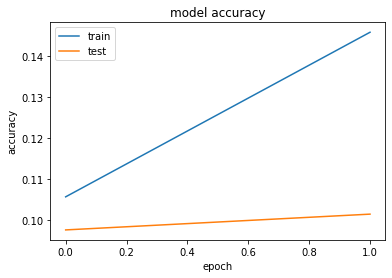

In [49]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

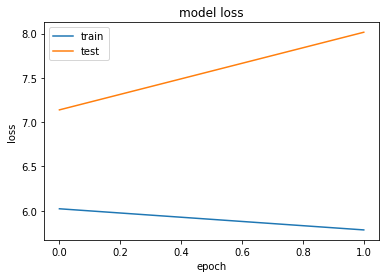

In [50]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


In [75]:
SEQUENCE_LENGTH=1
def prepare_input(text):
  chars = list(text)
  char_indices = dict((c, i) for i, c in enumerate(chars))
  x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))
  for t, char in enumerate(text):
      x[0, t, char_indices[char]] = 1.
        
  return x

In [ ]:
prepare_input("This is an example of input for our LSTM".lower())

In [57]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    return heapq.nlargest(top_n, range(len(preds)), preds.take)


In [65]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion


In [66]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]


In [67]:
quotes = [
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
    "That which does not kill us makes us stronger.",
    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you.",
    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
    "It is hard enough to remember my opinions, without also remembering my reasons for them!"
]


In [68]:
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()


it is not a lack of love, but a lack of 


NameError: ignored